In [5]:
__imp

In [6]:
import cv2

In [114]:
def get_image_cv2(path):
    img = cv2.imread(path, -1)
    img = img[:, :, :3]
    img = img[:, :, ::-1]
    return img

In [115]:
img = get_image_cv2('/sdg/rawr/synthetic/Blacks2012,Clarity2012,Contrast2012,Exposure2012,Highlights2012,Saturation,Shadows2012,Temperature,Tint,Whites2012/png/ffd8d3d0e816c00df547048d15413683_0.png')

In [133]:
# def imresize_single_image(image, sizes, interpolation=None):
#     """
#     Resizes a single image.
#     Parameters
#     ----------
#     image : (H,W,C) ndarray or (H,W) ndarray
#         Array of the image to resize.
#         Expected to usually be of dtype uint8.
#     sizes : iterable of two ints
#         See `imresize_many_images()`.
#     interpolation : None or string or int, optional(default=None)
#         See `imresize_many_images()`.
#     Returns
#     -------
#     out : (H',W',C) ndarray or (H',W') ndarray
#         The resized image.
#     """
#     grayscale = False
#     if image.ndim == 2:
#         grayscale = True
#         image = image[:, :, np.newaxis]
#     do_assert(len(image.shape) == 3, image.shape)
#     rs = imresize_many_images(image[np.newaxis, :, :, :], sizes, interpolation=interpolation)
#     if grayscale:
#         return np.squeeze(rs[0, :, :, 0])
#     else:
#         return rs[0, ...]
    
# class ScaleUINT16(iaa.Scale):
#     def _augment_images(self, images, random_state, parents, hooks):
#         result = []
#         nb_images = len(images)
#         samples_h, samples_w, samples_ip = self._draw_samples(nb_images, random_state, do_sample_ip=True)
#         for i in range(nb_images):
#             image = images[i]
#             ia.do_assert((image.dtype == np.uint8) or (image.dtype == np.uint16), "Scale() can currently only process images of dtype uint8 or uint16 (got %s)" % (image.dtype,))
#             sample_h, sample_w, sample_ip = samples_h[i], samples_w[i], samples_ip[i]
#             h, w = self._compute_height_width(image.shape, sample_h, sample_w)
#             print(image.dtype)
#             image_rs = ia.imresize_single_image(image, (h, w), interpolation=sample_ip)
#             result.append(image_rs)
#             print(image_rs.dtype)

#         if not isinstance(images, list):
#             all_same_size = (len(set([image.shape for image in result])) == 1)
#             if all_same_size:
#                 result = np.array(result, dtype=result[0].dtype)

#         return result

In [134]:
def resize_cv2_(images, random_state, parents, hooks, resolution, interpolation):
    
    return [cv2.resize(img, (resolution['width'], resolution['height']), interpolation=interpolation) for img in images]

def resize_cv2_kp(keypoints_on_images, random_state, parents, hooks):
    print('Not implemented')
    return keypoints_on_images

def ResizeCV2(resolution, interpolation):
    return LambdaKW(
                    func_images=resize_cv2_,
                    func_keypoints=resize_cv2_kp,
                    resolution=resolution,
                    interpolation=interpolation
    )



In [139]:
seq_geom1 = iaa.Sequential([
                RandomCrop(200, shared_crop=True),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5), 
                ResizeCV2({"height":200, "width":300}, cv2.INTER_CUBIC)
            ])
a0 =seq_geom1.augment_image(img)

In [142]:
if a0.dtype == np.uint16:
    print(1)

1


In [147]:
q = cv2.imwrite('d.png', img[:, :, ::-1])

In [192]:
from __future__ import division

import torch
import numpy

def rgb2lab(img_in):
    '''
    transformation froim RGB to Lab.
    Input:
        img_in: (bsz, c, h, w) tensor of rgb image batch with value range (-1, 1)
    Output:
        img_out: (bsz, c, h, w) tensof of Lab image batch.
    '''
    bsz, c, h, w = img_in.size()
    rgb = img_in
    
#     rgb = (img_in + 1 + 1e-5) * 0.5
    # convert to XYZ space
    # rgb = torch.where(rgb>0.04045, torch.pow((rgb+0.055)/1.055, 2.4), rgb/12.92)
    # x = (rgb[:,0]*0.4124 + rgb[:,1]*0.3576 + rgb[:,2]*0.1805) / 0.95047
    # y = (rgb[:,0]*0.2126 + rgb[:,1]*0.7152 + rgb[:,2]*0.0722) / 1.
    # z = (rgb[:,0]*0.0193 + rgb[:,1]*0.1192 + rgb[:,2]*0.9505) / 1.08883
    # xyz = torch.stack([x,y,z], dim=1)
    # xyz = torch.where(xyz>0.008856, torch.pow(xyz, 1./3), 7.787*xyz + 16./116)
    
    m1 = (rgb > 0.04045).float()
    rgb = torch.pow((rgb+0.055)/1.055, 2.4) * m1 + rgb/12.92*(1-m1)
    M1 = [[0.4124/0.95047, 0.3576/0.95047, 0.1805/0.95047], \
          [0.2126, 0.7152, 0.0722],\
          [0.0193/1.08883, 0.1192/1.08883, 0.9505/1.08883]]
    M1 = rgb.new(M1).view(1,3,3)
    xyz = torch.matmul(M1, rgb.view(bsz, c, h*w)).view(bsz, c, h, w)
    m2 = (xyz>0.008856).float()
    xyz = torch.pow(xyz, 1./3)*m2 + (xyz*7.787+16./116)*(1-m2)
    
    # Convert to Lab space
    l = 116. * xyz[:,1] - 16
    a = 500. * (xyz[:,0] - xyz[:,1])
    b = 200. * (xyz[:,1] - xyz[:,2])
    
    return torch.stack([l,a,b], dim=1)


def lab2rgb(img_in):
    '''
    transformation from Lab to RGB
    Input:
        img_in: (bsz, c, h, w) tensor of Lab image batch 
    Output:
        img_out: (bsz, c, h, w) tensof of rgb image batch with value range (-1, 1)
    '''
    
    # Convert to XYZ space
    y = (img_in[:,0] + 16.) / 116
    x = img_in[:, 1] / 500. + y
    z = y - img_in[:, 2] / 200.
    xyz = torch.stack([x, y, z], dim=1)
    xyz_pow_3 = xyz.pow(3)
    xyz = torch.where(xyz_pow_3 > 0.008856, xyz_pow_3, (xyz-16./116)/7.787)
    xyz = xyz * xyz.new([0.95047, 1.0, 1.08883]).view(1,3,1,1)
    
    # Convert to RGB space
    r = xyz[:,0]*  3.2406 + xyz[:,1]* -1.5372 + xyz[:,2]* -0.4986
    g = xyz[:,0]* -0.9689 + xyz[:,1]*  1.8758 + xyz[:,2]*  0.0415
    b = xyz[:,0]*  0.0557 + xyz[:,1]* -0.2040 + xyz[:,2]*  1.0570

    rgb = torch.stack([r,g,b], dim=1)
    rgb = torch.where(rgb>0.0031308, 1.055*rgb.pow(1./2.4)-0.055, rgb*12.92)
    
    return rgb

In [154]:
def pil_to_np(img_PIL):
    '''Converts image in PIL format to np.array.
    
    From W x H x C [0...255] to C x W x H [0..1]
    '''
    ar = np.array(img_PIL)

    if len(ar.shape) == 3:
        ar = ar.transpose(2,0,1)
    else:
        ar = ar[None, ...]

    return ar.astype(np.float32) / 255.

def np_to_pil(img_np): 
    '''Converts image in np.array format to PIL image.
    
    From C x W x H [0..1] to  W x H x C [0...255]
    '''
    ar = np.clip(img_np*255,0,255).astype(np.uint8)
    
    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)

def np_to_torch(img_np):
    '''Converts image in numpy.array to torch.Tensor.
    From C x W x H [0..1] to  C x W x H [0..1]
    '''
    return torch.from_numpy(img_np)[None, :]

def torch_to_np(img_var):
    '''Converts an image in torch.Tensor format to np.array.
    From 1 x C x W x H [0..1] to  C x W x H [0..1]
    '''
    return img_var.detach().cpu().numpy()[0]

In [170]:
i = torch.from_numpy(img.transpose(2,0,1).astype(np.float32)/65535.)[None,...]
q = rgb2lab(i)

In [189]:
q[:,0,:,:].min(), q[:,0,:,:].max()

(tensor(0.), tensor(100.))

In [190]:
q[:,1,:,:].min(), q[:,1,:,:].max()

(tensor(-40.3785), tensor(89.3184))

In [191]:
q[:,2,:,:].min(), q[:,2,:,:].max()

(tensor(-91.1685), tensor(77.2446))

/home/dulyanov/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


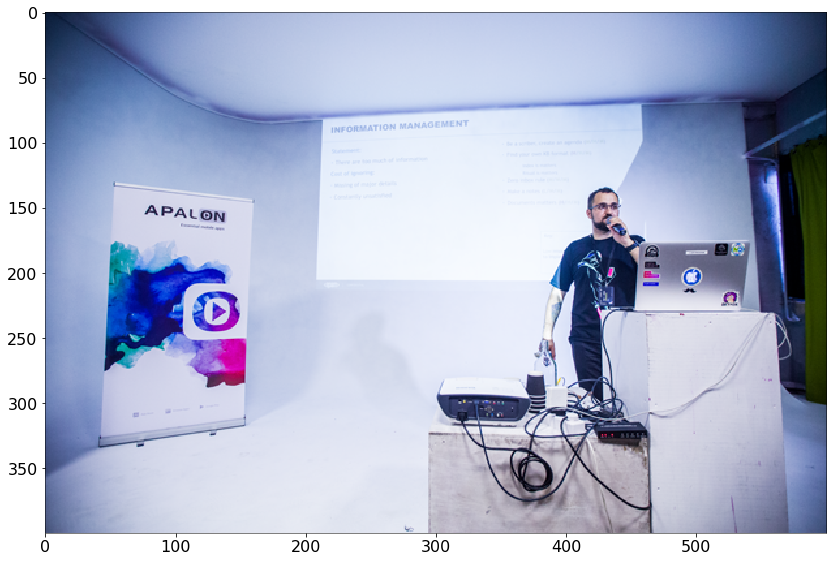

In [181]:
plt.imshow(img/65536)

/home/dulyanov/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


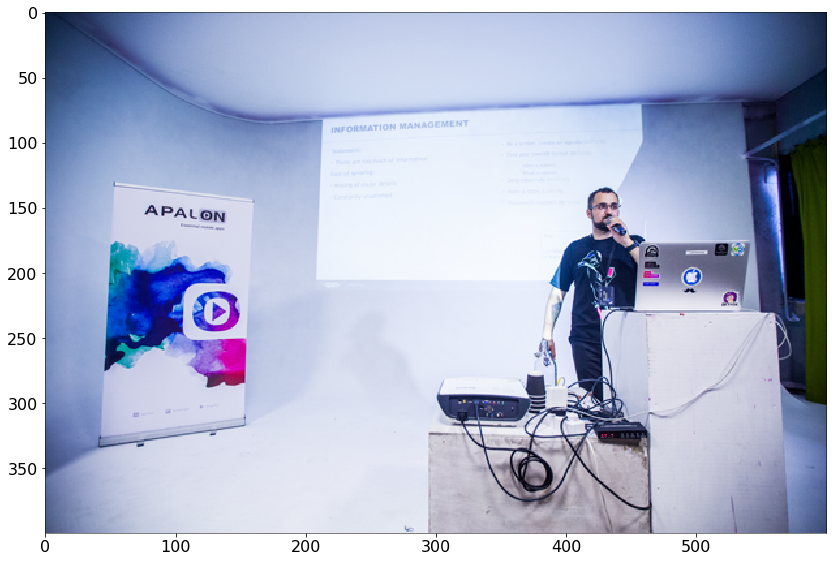

In [179]:
plt.imshow((lab2rgb(q)[0].numpy().transpose(1,2,0)*255).astype(np.uint8))

In [158]:
img.transpose(2,0,1).shape

(3, 400, 600)

In [119]:
seq_geom = iaa.Sequential([
#                 RandomCrop(200, shared_crop=True),
#                 iaa.Fliplr(0.5),
#                 iaa.Flipud(0.5), 
                iaa.Scale({"height":200, "width":300}, 'cubic')
            ])
a1 = seq_geom1.augment_image(img)

In [120]:
class LambdaKW(Augmenter):
    def __init__(self, func_images, func_keypoints, name=None, deterministic=False, random_state=None, **kwargs):
        super(LambdaKW, self).__init__(name=name, deterministic=deterministic, random_state=random_state)
        self.func_images = func_images
        self.func_keypoints = func_keypoints
        self.kwargs = kwargs


    def _augment_images(self, images, random_state, parents, hooks):
        return self.func_images(images, random_state, parents=parents, hooks=hooks, **self.kwargs)

    def _augment_keypoints(self, keypoints_on_images, random_state, parents, hooks):
        result = self.func_keypoints(keypoints_on_images, random_state, parents=parents, hooks=hooks, **self.kwargs)
        ia.do_assert(isinstance(result, list))
        ia.do_assert(all([isinstance(el, ia.KeypointsOnImage) for el in result]))
        return result

    def get_parameters(self):
        return []


In [125]:
a0

array([[[ 79,  74,  39],
        [186,  67, 191],
        [  8,  81, 224],
        ...,
        [ 14, 218, 251],
        [ 79, 214, 150],
        [136, 226,  57]],

       [[ 95, 195, 114],
        [101, 205, 195],
        [217, 240, 230],
        ...,
        [221, 198,  34],
        [ 50, 210, 200],
        [103,  12, 196]],

       [[ 52, 247, 134],
        [106,  90,  81],
        [252, 118,  91],
        ...,
        [205, 129, 206],
        [ 30, 159, 173],
        [  4,  53, 204]],

       ...,

       [[195, 235, 189],
        [250,  48,  32],
        [107, 157, 181],
        ...,
        [168,  71, 149],
        [175, 242, 156],
        [193,   6,  74]],

       [[127, 130,  42],
        [250, 106, 183],
        [ 92, 219, 105],
        ...,
        [251, 186, 247],
        [109,  55, 109],
        [103,  56, 109]],

       [[117, 126, 112],
        [ 38, 144,  95],
        [216, 218,  19],
        ...,
        [ 37,  19, 252],
        [117, 209,  80],
        [221, 170, 126]]

In [15]:
from imgaug import augmenters as iaa
from imgaug.augmenters import Augmenter
import imgaug as ia
import cv2

# -------- -----------------------------------
# -------- GaussianBlurCV2 -------------------
# --------------------------------------------

class GaussianBlurCV2(iaa.GaussianBlur): # pylint: disable=locally-disabled, unused-variable, line-too-long

    def _augment_images(self, images, random_state, parents, hooks):
        result = images
        nb_images = len(images)
        samples = self.sigma.draw_samples((nb_images,), random_state=random_state)
        for i in range(nb_images):
            nb_channels = images[i].shape[2]
            sig = samples[i]
            if sig > 0 + self.eps:
                kernel_size = int(4 * sig) | 1
                kernel = cv2.getGaussianKernel(kernel_size, sig, cv2.CV_32F)
                result[i] = cv2.sepFilter2D(images[i], -1, kernel, kernel)

        return result

    def _augment_keypoints(self, keypoints_on_images, random_state, parents, hooks):
        return keypoints_on_images
    


# -------- -----------------------------------
# -------- LambdaKW --------------------------
# --------------------------------------------


class LambdaKW(Augmenter):
    def __init__(self, func_images, func_keypoints, name=None, deterministic=False, random_state=None, **kwargs):
        super(LambdaKW, self).__init__(name=name, deterministic=deterministic, random_state=random_state)
        self.func_images = func_images
        self.func_keypoints = func_keypoints
        self.kwargs = kwargs


    def _augment_images(self, images, random_state, parents, hooks):
        return self.func_images(images, random_state, parents=parents, hooks=hooks, **self.kwargs)

    def _augment_keypoints(self, keypoints_on_images, random_state, parents, hooks):
        result = self.func_keypoints(keypoints_on_images, random_state, parents=parents, hooks=hooks, **self.kwargs)
        ia.do_assert(isinstance(result, list))
        ia.do_assert(all([isinstance(el, ia.KeypointsOnImage) for el in result]))
        return result

    def get_parameters(self):
        return []


# -------------------------------------------------
# ------------- LambdaKW --------------------------
# -------------------------------------------------


def get_crop_xy(img, crop_size, random_state):
    h, w = img.shape[0], img.shape[1]
        
    x = random_state.randint(0, w - crop_size - 1)
    y = random_state.randint(0, h - crop_size - 1)
    
    return x, y


def crop_images(images, random_state, parents, hooks, **kwargs):

    if kwargs['shared_crop']:
        assert len(set([x.shape[0] for x in images])) == 1
        assert len(set([x.shape[1] for x in images])) == 1
        
        x, y = get_crop_xy(images[0], kwargs['crop_size'], random_state)        
    
    out = []
    for img in images:
        
        if not kwargs['shared_crop']:
            x, y = get_crop_xy(img, kwargs['crop_size'], random_state)
    
        out.append(img[y: y + kwargs['crop_size'], x: x + kwargs['crop_size']])

    return out


def crop_keypoints(keypoints_on_images, random_state, parents, hooks):
    print('Not implemented')
    return keypoints_on_images


def RandomCrop(crop_size, shared_crop):
    return LambdaKW(
                    func_images=crop_images,
                    func_keypoints=crop_keypoints,
                    crop_size=crop_size,
                    shared_crop=shared_crop
    )



In [14]:
from dataloaders.augmenters import RandomCrop

ModuleNotFoundError: No module named 'dataloaders'

In [9]:
!ls /sdg/rawr/synthetic/Blacks2012,Clarity2012,Contrast2012,Exposure2012,Highlights2012,Saturation,Shadows2012,Temperature,Tint,Whites2012/png | tail -n 10

ffd8d3d0e816c00df547048d15413683_0.png
ffdce131bf4d98ed0f01712e29bf0567_0.png
ffdee5f3fc7b3b1dda169b6a20cfc5be_0.png
ffe19c60968314e7bc1a7815cfaba950_0.png
ffe58475340332cdec572d580d0365f1_0.png
ffeb5de46a1f3c7e29ad823528322982_0.png
ffed113b1999cea47b29b4c7e7ab436d_0.png
fffc71a85855b5c7caac74b2b69d3b2c_0.png
fffd0ecff9a3d68baef6961b8dc13fe4_0.png
ffff04c607dab6c07f2b8ae7ab8bde5d_0.png


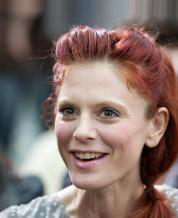

In [2]:
from PIL import Image
import numpy as np

img_ = Image.open('/sdh/data/celebA/all_imgs/000002.jpg')
img_

In [145]:
import imgaug as ia
from imgaug import augmenters as iaa


sometimes = lambda aug: iaa.Sometimes(0.4, aug)
often = lambda aug: iaa.Sometimes(0.8, aug)

# seq = iaa.Sequential([
    
#     iaa.Fliplr(0.5),  # horizontally flip 50% of the images
#     often(iaa.Affine(
#         # scale images to 80-120% of their size, individually per axis
#         scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
#         # translate by -20 to +20 percent (per axis)
#         translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
#         rotate=(-8, 8),  # rotate by -45 to +45 degrees
#         shear=(-5, 5),  # shear by -16 to +16 degrees
#         order=[3],  # use nearest neighbour or bilinear interpolation (fast)
#         cval=(0),  # if mode is constant, use a cval between 0 and 255
#         # use any of scikit-image's warping modes (see 2nd image from the top for examples)
#         mode='constant', 
#     )),
#     sometimes(iaa.Add((-8, 8))), # change brightness of images (by -10 to 10 of original value)
#     sometimes(iaa.AddToHueAndSaturation((-8, 8))), # change hue and saturation
#     sometimes(iaa.PiecewiseAffine(scale=(0.00, 0.02), order=3)),
#     sometimes(iaa.ContrastNormalization((0.5, 1.5))),
#     often(iaa.GaussianBlur(sigma=(0, 0.3))),  # blur images with a sigma of 0 to 3.0
# #     (iaa.ElasticTransformation(alpha=(0.0, 1.5), sigma=(9.0, 10))),
    
# ])


seq = iaa.Sequential([
    
    iaa.Fliplr(0.5),  # horizontally flip 50% of the images
    often(iaa.CropAndPad(
            percent=(-0.05, 0.05),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
    often(iaa.Affine(
            scale={"x": (0.85, 1.15), "y": (0.85, 1.15)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
            rotate=(-25, 25), # rotate by -45 to +45 degrees
            shear=(-12, 12), # shear by -16 to +16 degrees
            order=[0, 1, 3], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL, # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            backend='cv2'
        )),
    sometimes(iaa.Add((-10, 10))), # change brightness of images (by -10 to 10 of original value)
    sometimes(iaa.AddToHueAndSaturation((-10, 8))), # change hue and saturation
#         (iaa.PiecewiseAffine(scale=(0.00, 0.02), order=3)),
    sometimes(iaa.ContrastNormalization((0.5, 1.5))),
    sometimes(iaa.GaussianBlur(sigma=(0, 0.7))),  # blur images with a sigma of 0 to 3.0
#         (iaa.ElasticTransformation(alpha=(0.0, 1.5), sigma=(9.0, 10))),
])


In [4]:
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
#         iaa.SomeOf((0, 5),
#             [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.ContrastNormalization((0.5, 2.0))
                    )
                ]),
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                (iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                (iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                (iaa.PerspectiveTransform(scale=(0.01, 0.1)))
#             ],
#             random_order=True
#         )
    ],
    random_order=True
)


In [387]:
nn.Conv2d??

In [386]:
import torch.nn as nn

In [26]:
import imgaug
from imgaug.augmenters import Augmenter

In [ ]:
def func_images(images, random_state, parents, hooks, **kwargs):
    
    random
    blur_size = int(4 * sigma) | 1
    q = random_state.rand(*shape[:2]) * 2 - 1
    dx = alpha * cv2.GaussianBlur(q, ksize=(blur_size, blur_size), sigmaX=sigma)  # .reshape(shape[0], shape[1], 1)

    
    if kwargs['shared_crop']:
        assert len(set([x.shape[0] for x in images])) == 1
        assert len(set([x.shape[1] for x in images])) == 1
        
        x, y = get_crop_xy(images[0], kwargs['crop_size'], random_state)        
    
    out = []
    for img in images:
        
        if not kwargs['shared_crop']:
            x, y = get_crop_xy(img, kwargs['crop_size'], random_state)
    
        out.append(img[y: y + kwargs['crop_size'], x: x + kwargs['crop_size']])

    return out


def func_keypoints(keypoints_on_images, random_state, parents, hooks):
    print('Not implemented')
    return keypoints_on_images

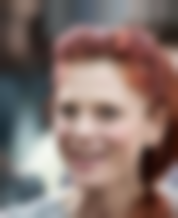

In [228]:
class GaussianBlurCV2(iaa.GaussianBlur): # pylint: disable=locally-disabled, unused-variable, line-too-long

    def _augment_images(self, images, random_state, parents, hooks):
        result = images
        nb_images = len(images)
        samples = self.sigma.draw_samples((nb_images,), random_state=random_state)
        for i in range(nb_images):
            nb_channels = images[i].shape[2]
            sig = samples[i]
            if sig > 0 + self.eps:
                kernel_size = int(4 * sig) | 1
                kernel = cv2.getGaussianKernel(kernel_size, sig, cv2.CV_32F)
                result[i] = cv2.sepFilter2D(images[i], -1, kernel, kernel)

        return result

    def _augment_keypoints(self, keypoints_on_images, random_state, parents, hooks):
        return keypoints_on_images
    
seq = iaa.Sequential([
    GaussianBlurCV2(sigma=5),   
])


Image.fromarray(seq.augment_image(np.array(img_)))

CPU times: user 3.78 ms, sys: 0 ns, total: 3.78 ms
Wall time: 3.36 ms


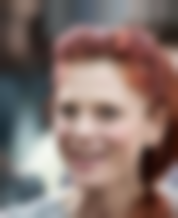

In [231]:
%time  Image.fromarray(seq.augment_image(np.array(img_)))

In [349]:
def elastic_transform(images, random_state, parents, hooks, alpha, sigma, alpha_affine):
    '''
        n01z3
    '''
    
    print (sigma)
    out = []
    for image in images:
#         if random_state is None:
#             random_state = np.random.RandomState(None)

        shape = image.shape
        shape_size = shape[:2]

        # Random affine
#         center_square = np.float32(shape_size) // 2
#         square_size = min(shape_size) // 3
#         pts1 = np.float32([center_square + square_size, [center_square[0] + square_size, center_square[1] - square_size],
#                            center_square - square_size])
#         pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
#         M = cv2.getAffineTransform(pts1, pts2)
#         image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

        blur_size = int(4 * sigma) | 1
        q = random_state.rand(*shape[:2]) * 2 - 1
        print(q[0])
        dx = alpha * cv2.GaussianBlur(q, ksize=(blur_size, blur_size), sigmaX=sigma)  # .reshape(shape[0], shape[1], 1)

        q = random_state.rand(*shape[:2]) * 2 - 1
        dy = alpha * cv2.GaussianBlur(q, ksize=(blur_size, blur_size), sigmaX=sigma)  # .reshape(shape[0], shape[1], 1)

        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        out.append(cv2.remap(image, (x + dx).astype(np.float32), (y + dy).astype(np.float32),
                         interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101))
    
    return out

In [383]:
import glob
img_dirs = ['/sdg/rawr/auto/jpg', '/sdg/rawr/as-shot/jpg']
# dfs = []

def fname(x):
    return '.'.join(os.path.basename(x).split('.')[:-1])

dfs = []
names = None
for i, img_dir in enumerate(img_dirs):
    img_paths = glob.glob(f'{img_dir}/f*')

    df = pd.DataFrame(img_paths, columns=[f'img{i}_path'])
    df['name'] = df[f'img{i}_path'].apply(fname)

    dfs.append(df)        

    
d = dfs[0]

for df in dfs[1:]:
    d = d.join(df.set_index('name'), how='inner', on='name')

In [384]:
d

,img0_path,name,img1_path
0,/sdg/rawr/auto/jpg/f145365ba0b42f7569f48a4724c...,f145365ba0b42f7569f48a4724c6bb7d,/sdg/rawr/as-shot/jpg/f145365ba0b42f7569f48a47...
1,/sdg/rawr/auto/jpg/f03868f505cc3843ee18faec825...,f03868f505cc3843ee18faec8251d8f0,/sdg/rawr/as-shot/jpg/f03868f505cc3843ee18faec...
2,/sdg/rawr/auto/jpg/f54d68e89811d77b427a5ba6369...,f54d68e89811d77b427a5ba63691adeb,/sdg/rawr/as-shot/jpg/f54d68e89811d77b427a5ba6...
3,/sdg/rawr/auto/jpg/ffb5849e25b079ecc4cb68de506...,ffb5849e25b079ecc4cb68de506673b9,/sdg/rawr/as-shot/jpg/ffb5849e25b079ecc4cb68de...
4,/sdg/rawr/auto/jpg/f3bfdb52960333da16314816dfc...,f3bfdb52960333da16314816dfcb250f,/sdg/rawr/as-shot/jpg/f3bfdb52960333da16314816...
5,/sdg/rawr/auto/jpg/ffaff2275f83f2f29c19e1cd2b6...,ffaff2275f83f2f29c19e1cd2b6a37f5,/sdg/rawr/as-shot/jpg/ffaff2275f83f2f29c19e1cd...
6,/sdg/rawr/auto/jpg/f9164b99bb0dcf8c91d4b029410...,f9164b99bb0dcf8c91d4b029410a5bd5,/sdg/rawr/as-shot/jpg/f9164b99bb0dcf8c91d4b029...
7,/sdg/rawr/auto/jpg/f286a25819c5c36ec0fceaf9751...,f286a25819c5c36ec0fceaf9751353e2,/sdg/rawr/as-shot/jpg/f286a25819c5c36ec0fceaf9...
8,/sdg/rawr/auto/jpg/f8783aba15ea13573d465359469...,f8783aba15ea13573d465359469af7bc,/sdg/rawr/as-shot/jpg/f8783aba15ea13573d465359...
9,/sdg/rawr/auto/jpg/f0741110581981dfbe82c4d716d...,f0741110581981dfbe82c4d716dbfd19,/sdg/rawr/as-shot/jpg/f0741110581981dfbe82c4d7...


In [377]:
dfs[1]

,img1_path,names
0,/sdg/rawr/as-shot/jpg/f145365ba0b42f7569f48a47...,f145365ba0b42f7569f48a4724c6bb7d
1,/sdg/rawr/as-shot/jpg/f03868f505cc3843ee18faec...,f03868f505cc3843ee18faec8251d8f0
2,/sdg/rawr/as-shot/jpg/f54d68e89811d77b427a5ba6...,f54d68e89811d77b427a5ba63691adeb
3,/sdg/rawr/as-shot/jpg/ffb5849e25b079ecc4cb68de...,ffb5849e25b079ecc4cb68de506673b9
4,/sdg/rawr/as-shot/jpg/f3bfdb52960333da16314816...,f3bfdb52960333da16314816dfcb250f
5,/sdg/rawr/as-shot/jpg/ffaff2275f83f2f29c19e1cd...,ffaff2275f83f2f29c19e1cd2b6a37f5
6,/sdg/rawr/as-shot/jpg/f9164b99bb0dcf8c91d4b029...,f9164b99bb0dcf8c91d4b029410a5bd5
7,/sdg/rawr/as-shot/jpg/f286a25819c5c36ec0fceaf9...,f286a25819c5c36ec0fceaf9751353e2
8,/sdg/rawr/as-shot/jpg/f8783aba15ea13573d465359...,f8783aba15ea13573d465359469af7bc
9,/sdg/rawr/as-shot/jpg/f0741110581981dfbe82c4d7...,f0741110581981dfbe82c4d716dbfd19


In [373]:
d.set_index('names')

,img1_path
names,
f145365ba0b42f7569f48a4724c6bb7d,/sdg/rawr/as-shot/jpg/f145365ba0b42f7569f48a47...
f03868f505cc3843ee18faec8251d8f0,/sdg/rawr/as-shot/jpg/f03868f505cc3843ee18faec...
f54d68e89811d77b427a5ba63691adeb,/sdg/rawr/as-shot/jpg/f54d68e89811d77b427a5ba6...
ffb5849e25b079ecc4cb68de506673b9,/sdg/rawr/as-shot/jpg/ffb5849e25b079ecc4cb68de...
f3bfdb52960333da16314816dfcb250f,/sdg/rawr/as-shot/jpg/f3bfdb52960333da16314816...
ffaff2275f83f2f29c19e1cd2b6a37f5,/sdg/rawr/as-shot/jpg/ffaff2275f83f2f29c19e1cd...
f9164b99bb0dcf8c91d4b029410a5bd5,/sdg/rawr/as-shot/jpg/f9164b99bb0dcf8c91d4b029...
f286a25819c5c36ec0fceaf9751353e2,/sdg/rawr/as-shot/jpg/f286a25819c5c36ec0fceaf9...
f8783aba15ea13573d465359469af7bc,/sdg/rawr/as-shot/jpg/f8783aba15ea13573d465359...


In [357]:
__imp

2
[-0.21577866 -0.86049303 -0.59571479  0.58800748  0.7918614  -0.43435638
 -0.61927812 -0.94655099  0.89539478  0.36770985  0.91406021  0.72769837
 -0.31906681 -0.77463391 -0.00188641 -0.9463724  -0.70016674 -0.53313474
  0.33129319  0.01975495 -0.39516089  0.1295368  -0.7495947   0.51141625
  0.42407028 -0.56699465  0.21278311  0.00660521 -0.87836738 -0.44369217
  0.99896541 -0.80092868  0.01282261  0.69866751 -0.39869625 -0.47858272
  0.7815861  -0.39034011  0.30298662  0.48062597  0.5772355   0.98951927
  0.60638414  0.31402431  0.79092712  0.81148927  0.94633292  0.55293053
 -0.61014534  0.41961218 -0.84974312 -0.36407414 -0.76838498  0.89988521
 -0.32249178  0.42643129  0.14263687 -0.78497717  0.1226889   0.32204709
  0.76303451 -0.85982872 -0.40873203  0.38468189 -0.93133673 -0.59289309
 -0.56265921  0.33865283 -0.42807864  0.19919132  0.93069689  0.58648596
 -0.33419439 -0.05520006 -0.5986522  -0.96855998 -0.4205692  -0.26118278
  0.12873435  0.8881333   0.89570415 -0.8598034  

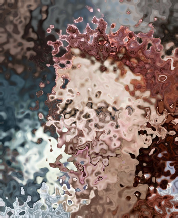

In [354]:
def crop_keypoints(keypoints_on_images, random_state, parents, hooks):
    print('Not implemented')
    return keypoints_on_images

et  = LambdaKW(
                    func_images=elastic_transform,
                    func_keypoints=crop_keypoints,
                    alpha=100,
                    sigma=2,
                    alpha_affine=5,
    )

Image.fromarray(et.augment_image(np.array(img_)))

In [186]:
import cv2

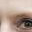

In [177]:
Image.fromarray(seq.augment_image(np.array(img_)))

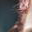

In [178]:
seq = seq.to_deterministic()
qq = seq.augment_images([np.array(img_), np.array(img_)])

Image.fromarray(qq[0])

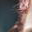

In [179]:
Image.fromarray(qq[1])

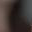

In [184]:
# seq = seq.to_deterministic()
qq = seq.augment_images([np.array(img_), np.array(img_)])

Image.fromarray(qq[0])


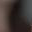

In [185]:
Image.fromarray(qq[1])

In [105]:
img__ = np.array(img_)
seq.augment_image(img__);

In [212]:
%timeit seq.augment_image(img__)

563 µs ± 9.18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [220]:
%timeit seq.augment_image(img__)

5.46 ms ± 82.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [194]:
import torch
import torch.nn as nn
import torchvision.models as models

class LocalFeatureNet (nn.Module):
           
    def __init__(self):
        super (LocalFeatureNet, self).__init__()
        
        self.relu  = nn.ReLU (inplace = True)
        
        self.conv1 = nn.Conv2d (in_channels = 3,   out_channels = 8, kernel_size = 3, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d (in_channels = 8,  out_channels = 16,  kernel_size = 3, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d (in_channels = 16, out_channels = 32,  kernel_size= 3, stride = 2,padding = 1)
        self.conv4 = nn.Conv2d (in_channels = 32, out_channels = 64,  kernel_size = 3, stride = 2, padding = 1)
        
        
        self.localconv1 = nn.Conv2d (in_channels = 64, out_channels = 64,  kernel_size = 3, stride = 1, padding = 1)
        self.localconv2 = nn.Conv2d (in_channels = 64, out_channels = 64,  kernel_size= 3, stride = 1, padding = 1)
        
        self.globalconv1 = nn.Conv2d (in_channels = 64, out_channels = 64,  kernel_size = 3, stride = 2,padding = 1)
        self.globalconv2 = nn.Conv2d (in_channels = 64, out_channels = 64,  kernel_size = 3, stride = 2, padding = 1)
        
        self.globalfc1 = nn.Linear (1024, 256)
        self.globalfc2 = nn.Linear (256, 128)
        self.globalfc3 = nn.Linear (128, 64)
        self.linear = nn.Conv2d(in_channels = 64, out_channels = 96,  kernel_size = 1, stride = 1)
        
        # Pixel Wise Network
        self.pixelwise_bias = nn.Parameter (torch.rand(3, 1), requires_grad=True)
        self.pixelwise_weight = nn.Parameter (torch.eye(3), requires_grad = True)
        self.pixelwise_obias = nn.Parameter (torch.eye(1), requires_grad = True)
        
        self.relu_slopes = nn.Parameter(torch.rand(3,16), requires_grad = True)
        self.relu_shifts = nn.Parameter(torch.rand(16,3), requires_grad = True)
        
    def custom_relu(self,channel,value):
        print("value",value.size())
        size = (16,value.size()[0],value.size()[1],value.size()[2])
        size_alt = (1L,value.size()[0],value.size()[1],value.size()[2])
        print("size: ",size,"size_alt",size_alt)
        value = value.expand(size)
        
#         print(self.relu_shifts[:,channel])
        a = self.relu_shifts[:,channel].clone()
        a = a.view(16,1,1,1)
#         print(a.data,a)
#         value = self.relu(value - a.repeat(size_alt))    
# Upper line is not working for some damn reason so I hard coded it for now.
#         print ("here ", a.repeat(1,1,img_h,img_w).size())
        value = self.relu(value - a.repeat(size[1],1,img_h,img_w))
        print("st ", value.size())
        print ("st2 ", self.relu_slopes.size())
        value = self.relu_slopes.matmul(value.view(img_h,img_w,16,-1))
        print ("stt ", value.size())
        value = value.view(-1,3,img_h,img_w)
        value = value[:,1,:,:]+value[:,2,:,:]+value[:,0,:,:]
        print ("stt2 ", value.size())
        return value
    
    def upsample(self, grid, bilat):
        sx = sy = 16
        d = 8
#         writer.add_scalar('upsample/sx', sx)
        writer.add_scalars('upsample/sizes', {"sx": sx,
                                              "sy": sy,
                                              "d": d })
#         g = grid.clone() 
        
        return torch.rand(1,img_h,img_w,3,4)
        
    def output(self, grid, inp):
        out = torch.rand(inp.size()[0],img_h,img_w,3)
        out = 0 * out
        grid = grid.view(-1,img_h,img_w,12)
        
        for i in range(0,3):
            out[:,:,:,i] = out[:,:,:,i] + grid[:,:,:,3+4*i]
            for j in range(0,3):
#                 print(grid[:,:,:,j+4*i].size())
#                 print(inp[:,j,:,:].size())
                a = torch.autograd.Variable(grid[:,:,:,j+4*i], requires_grad=False)
#                 a = a.numpy()
                b = inp[:,j,:,:]
#                 b = b.numpy()
                temp = a.data * b.data
#                 print(temp.size())
                out[:,:,:,i] = out[:,:,:,i] + temp
        
        return out
    
    def forward (self, h, l):
        
#         print (x.size())
        
        x = self.relu (self.conv1 (l))
        print ("conv1",x.size())
        x = self.relu (self.conv2 (x))
        print ("conv2",x.size())
        x = self.relu (self.conv3 (x))
        print ("conv3",x.size())
        x = self.relu (self.conv4 (x))
        print ("conv4",x.size())
#         print ("lel")
        y = self.localconv1 (x)
#         print (y.size())
        y = self.localconv2 (y)
        
#         print (y.size())
        
        z = self.globalconv1 (x)
        z = self.globalconv2 (z)
        z = self.globalfc1 (z.view(z.size()[0], -1))
        z = self.globalfc2 (z)
        z = self.globalfc3 (z)
        
#         print (z.size())
        
        
        fused = self.relu(z.view(-1,64,1,1)+y)
#         print (fused.size())
        
        lin = self.linear(fused)
#         print (lin.size())
        
        bilat = lin.view(-1, 8, 3, 4, 16, 16)
        
        
#         bilat = self.bilateralGrid (fused)
        
        print ("bilat",bilat.size())
        
#         return bilat

# pixel wise network
        for i in range(0,3):
            a = self.pixelwise_weight[i,:].view(-1,3)
            b = h.unsqueeze(0).view(3,-1)
            print(a.size(),b.size())
            p = torch.mm(a,b)
            print(p.size())
            p = p.view(h.size()[0],h.size()[2],h.size()[3]) + self.pixelwise_bias[i]
            print(p.size())
#             p = torch.bmm(self.pixelwise_weight[i,:], h.unsqueeze(0).view(3,-1)).view(h.size()) + self.pixelwise_bias[i]
            print(i)
            p += self.custom_relu(i,p)
        p += self.pixelwise_obias
        p = p.view(p.size()[0],1,p.size()[1],p.size()[2])
        print("p",p.size())
        grid = p
        writer.add_image('gridmap',grid)
        bilat_new = self.upsample(grid, bilat)
        
        return self.output(bilat_new,h)

SyntaxError: invalid syntax (<ipython-input-194-1bdeb2e91e52>, line 40)